In [1]:
import os
import codecs
import json
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.core.display import HTML as Center

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, recall_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline 
plt.style.use("ggplot")

Center("""<style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
</style>""")

In [2]:
root_directory = os.getcwd()
dataset_directory = os.path.join(root_directory, "datasets")
trained_model_directory = os.path.join(root_directory, "models")

dataset_normal_file_path = os.path.join(dataset_directory, "dataset-False.csv")
dataset_fire_file_path = os.path.join(dataset_directory, "dataset-True.csv")
fire_simulation_dataset = os.path.join(dataset_directory, "fire_sim.csv")
normal_simulation_dataset = os.path.join(dataset_directory, "normal_sim.csv")
fire_sim_json = os.path.join(dataset_directory, "fire_sim.json")
normal_sim_json = os.path.join(dataset_directory, "normal_sim.json")
analysis_dataset = os.path.join(dataset_directory, "analysis.csv")

target_field = "Fire"
class_labels = ["NON FIRE SIGNAL", "FIRE SIGNAL"]
colors = {0: '#0F5132', 1: '#842029'}
custom_diverging = LinearSegmentedColormap.from_list("CustomDiverging", [colors[0], "white", colors[1]])

normalizer = MinMaxScaler()
result_summary = dict()

In [3]:
def split_dataset_into_sim_analysis_dataset():
    normal_df = pd.read_csv(dataset_normal_file_path)
    fire_df = pd.read_csv(dataset_fire_file_path)

    split_normal_index = int(len(normal_df) * 0.9)
    split_fire_index = int(len(fire_df) * 0.9)

    normal_90 = normal_df.iloc[:split_normal_index]
    normal_10 = normal_df.iloc[split_normal_index:]

    fire_90 = fire_df.iloc[:split_fire_index]
    fire_10 = fire_df.iloc[split_fire_index:]

    analysis_df = pd.concat([fire_90, normal_90], ignore_index=True)
    sim_df = pd.concat([fire_10, normal_10], ignore_index=True)

    analysis_df.to_csv(analysis_dataset, index=False)
    fire_10.to_csv(fire_simulation_dataset, index=False)
    normal_10.to_csv(normal_simulation_dataset, index=False)

In [4]:
def process_simulation_json(dataset_file_path, json_file_path):
    simulation_df = pd.read_csv(dataset_file_path)
    simulation_df.drop([target_field], axis=1, inplace=True)
    json_list = simulation_df.to_dict(orient="records")
    json.dump(json_list, codecs.open(json_file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)
    print("\n\nComplete JSON data generation.\n\n")

In [5]:
def process_missing_data_analysis(dataset):
    print("\n\nANALYSE MISSING DATA\n\n")
    dataset = dataset.replace([np.inf, -np.inf], np.nan)
    dataset.dropna(inplace=True)
    print(dataset.isnull().sum())
    return dataset

In [6]:
def show_binary_class_distribution_for_sensor_dataset(dataset, class_labels, chart_title):
    explode = (0, 1)
    fig = plt.figure(figsize=(3, 3), dpi=300, tight_layout=False)
    plt.title("\n\n{}\n".format(chart_title))
    count = dataset[target_field].value_counts().sort_index()
    data = count.values

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return f'{pct:.1f}%\n({val:d})'
        return my_autopct

    plt.pie(data, labels=class_labels, autopct=make_autopct(data), colors=[colors[c] for c in count.index], radius=1.1)

In [7]:
def run_lr_analysis(X_train, X_test, y_train, y_test, result_summary):
    name = "LOGISTIC REGRESSION"
    abbr = "LR"
    param_grid = None
    model_saved_path = os.path.join(trained_model_directory, "{}.pkl".format(abbr.lower()))
    model = LogisticRegression(max_iter=1250000, random_state=0)
    if param_grid:
        model = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=5)
        
    result_summary[abbr] = run_model_analysis(model, X_train, X_test, y_train, y_test, name, abbr, model_saved_path)

In [8]:
def run_svm_analysis(X_train, X_test, y_train, y_test, result_summary):
    name = "SUPPORT VECTOR MACHINE"
    abbr = "SVM"
    param_grid = None
    model_saved_path = os.path.join(trained_model_directory, "{}.pkl".format(abbr.lower()))
    model = SVC()
    if param_grid:
        model = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=5)

    result_summary[abbr] = run_model_analysis(model, X_train, X_test, y_train, y_test, name, abbr, model_saved_path)

In [9]:
def run_dt_analysis(X_train, X_test, y_train, y_test, result_summary):
    name = "DECISION TREE"
    abbr = "DT"
    param_grid = None
    model_saved_path = os.path.join(trained_model_directory, "{}.pkl".format(abbr.lower()))
    model = DecisionTreeClassifier(criterion="entropy", max_depth = 5, random_state=0)
    if param_grid:
        model = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=5)

    result_summary[abbr] = run_model_analysis(model, X_train, X_test, y_train, y_test, name, abbr, model_saved_path)

In [10]:
def run_rf_analysis(X_train, X_test, y_train, y_test, result_summary):
    name = "RANDOM FOREST"
    abbr = "RF"
    param_grid = None
    model_saved_path = os.path.join(trained_model_directory, "{}.pkl".format(abbr.lower()))
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    if param_grid:
        model = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=5)

    result_summary[abbr] = run_model_analysis(model, X_train, X_test, y_train, y_test, name, abbr, model_saved_path)

In [11]:
def run_model_analysis(model, X_train, X_test, y_train, y_test, name, abbr, model_saved_path):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    try:
        joblib.dump(model, model_saved_path)
    except Exception as e:
        print("Attempt to save {} model to file FAILED!!!".format(model_saved_path))
        print(dir(e))

    confusion_matrix_summary = confusion_matrix(y_test, predictions)
    true_negative, false_positive, false_negative, true_positive = confusion_matrix_summary.ravel()

    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(confusion_matrix_summary, cmap=custom_diverging, annot=True, fmt='d', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title('CONFUSION MATRIX PLOT', fontsize=16)
    ax.set_xlabel('ACTUAL', fontsize=14)
    ax.set_ylabel('PREDICTION', fontsize=14)

    sensitivity = recall_score(y_test, predictions) * 100
    specificity = (true_negative / (true_negative + false_positive)) * 100
    accuracy = accuracy_score(y_test, predictions) * 100
    auc = roc_auc_score(y_test, predictions) * 100
    f_score = f1_score(y_test, predictions) * 100

    summary_metrics = f"SENSITIVITY: {sensitivity:.2f} %\nSPECIFICITY: {specificity:.2f} %\nACCURACY: {accuracy:.2f} %\nAUC: {auc:.2f} %\nF-SCORE: {f_score:.2f} %"
    plt.gcf().text(1.05, 0.5, summary_metrics, fontsize=12, bbox=dict(facecolor='white', alpha=0.5), transform=plt.gca().transAxes)
    plt.show()

    print("\n\n\n\n\n")
    
    return {
        "SENSITIVITY": sensitivity,
        "SPECIFICITY": specificity,
        "ACCURACY": accuracy,
        "AUC": auc,
        "F-SCORE": f_score
    }

In [12]:
if not os.path.exists(analysis_dataset):
    split_dataset_into_sim_analysis_dataset()

if not os.path.exists(fire_sim_json):
    process_simulation_json(fire_simulation_dataset, fire_sim_json)

if not os.path.exists(normal_sim_json):
    process_simulation_json(normal_simulation_dataset, normal_sim_json)

dataset_df = pd.read_csv(analysis_dataset)



Complete JSON data generation.




Complete JSON data generation.




In [13]:
dataset_df

,LPG,CO,Smoke,Temperature,Humidity,Fire
0,0.530074,5.124880,4.649366,44.637061,11.818723,1
1,0.638217,4.000907,5.454665,29.658258,12.729345,1
2,0.715519,4.938163,5.706111,34.469998,7.657068,1
3,0.595722,4.962329,4.479756,48.252218,9.834888,1
4,0.887163,3.355422,3.743743,49.354653,12.068474,1
...,...,...,...,...,...,...
895,0.000000,0.000000,0.102290,26.074899,29.569370,0
896,0.000000,0.000000,0.082680,43.136714,41.111058,0
897,0.000000,0.000000,0.105528,37.004549,27.692445,0
898,0.000000,0.000000,0.101236,41.560908,38.967430,0


In [14]:
dataset_df = process_missing_data_analysis(dataset_df)



ANALYSE MISSING DATA


LPG            0
CO             0
Smoke          0
Temperature    0
Humidity       0
Fire           0
dtype: int64


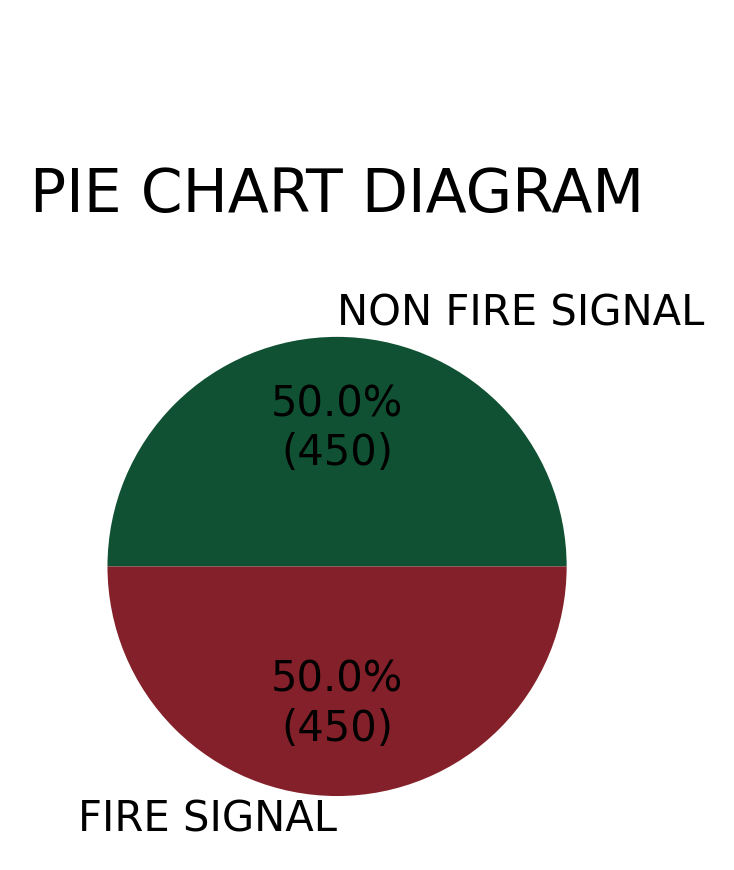

In [15]:
show_binary_class_distribution_for_sensor_dataset(dataset_df, class_labels, "PIE CHART DIAGRAM")

In [16]:
y = dataset_df[target_field]
X = dataset_df.drop([target_field], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.fit_transform(X_test)

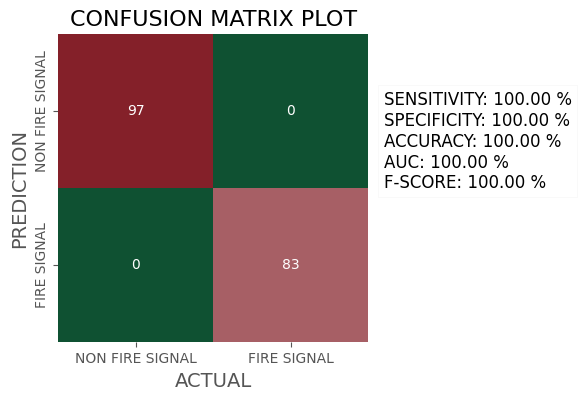

In [17]:
run_lr_analysis(X_train, X_test, y_train, y_test, result_summary)

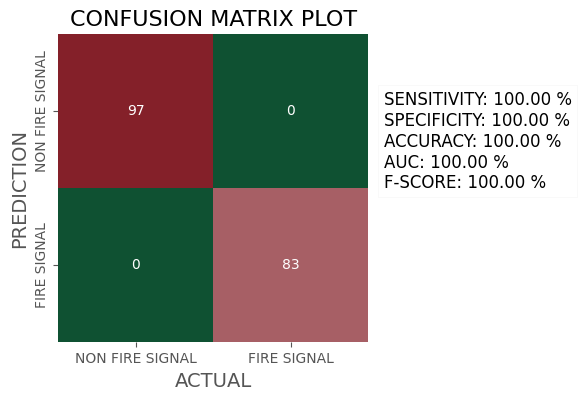

In [18]:
run_svm_analysis(X_train, X_test, y_train, y_test, result_summary)

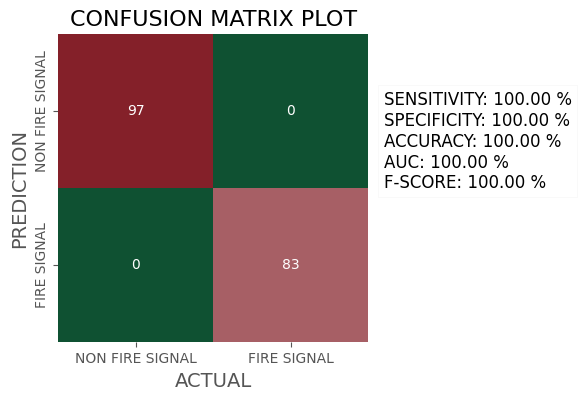

In [19]:
run_dt_analysis(X_train, X_test, y_train, y_test, result_summary)

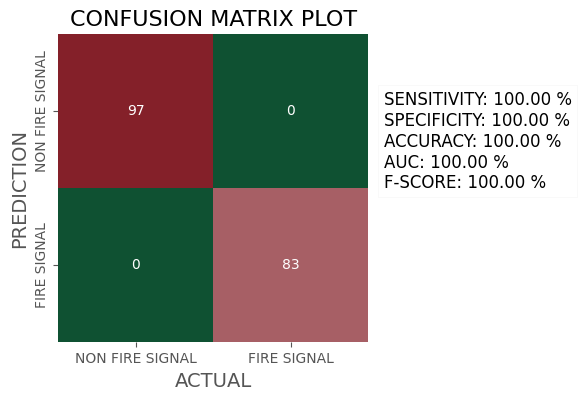

In [20]:
run_rf_analysis(X_train, X_test, y_train, y_test, result_summary)